In [197]:
from gerrychain import Graph

In [198]:
# Read Nebraska county graph from json file "NE_county.json"
filepath = r'C:\Users\Keegan\Downloads\districting-data-2020-county_NE\NE_county.json'

G = Graph.from_json(filepath)



In [199]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 3          # number of districts
total_population = sum(G.nodes[node]['POP100'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)


Using L = 650566 and U = 657103 and k = 3


In [200]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

In [201]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [202]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['POP100'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['POP100'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

m.update()

In [203]:
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 792 rows, 510 columns and 2916 nonzeros
Model fingerprint: 0xd96cbca1
Variable types: 0 continuous, 510 integer (510 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Found heuristic solution: objective 140.0000000
Presolve time: 0.00s
Presolved: 792 rows, 510 columns, 2916 nonzeros
Variable types: 0 continuous, 510 integer (510 binary)

Root relaxation: objective 0.000000e+00, 351 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  279  140.00000    0.00000   100%     -    0s
H    0     0                      96.0000000    0.00000   100%     -    0s
H    0     0   

In [204]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["POP100"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The number of cut edges is 16.0
District 0 has population 650600 and contains counties ['Sioux', 'Lincoln', 'Sherman', 'Logan', 'Merrick', 'Sheridan', 'Grant', 'Blaine', 'Dixon', 'Stanton', 'Wheeler', 'Franklin', 'Chase', 'Buffalo', 'Fillmore', 'York', 'Clay', 'Cheyenne', 'Garden', 'Harlan', 'Hooker', 'Furnas', 'Howard', 'Valley', 'Cedar', 'Thayer', 'Deuel', 'Morrill', 'Hall', 'Hamilton', 'Loup', 'Frontier', 'Nance', 'Knox', 'Perkins', 'Colfax', 'Butler', 'Cherry', 'Cuming', 'Nuckolls', 'Keith', 'Phelps', 'Webster', 'Dakota', 'Boyd', 'Thomas', 'Holt', 'Brown', 'Keya Paha', 'Banner', 'Greeley', 'Dundy', 'Scotts Bluff', 'Adams', 'Kearney', 'Hitchcock', 'Kimball', 'Custer', 'Polk', 'Dawes', 'Wayne', 'Garfield', 'Pierce', 'Platte', 'Box Butte', 'Thurston', 'Boone', 'Madison', 'McPherson', 'Red Willow', 'Rock', 'Gosper', 'Dawson', 'Arthur', 'Hayes', 'Antelope']
District 1 has population 654384 and contains counties ['Pawnee', 'Sarpy', 'Saunders', 'Seward', 'Richardson', 'Lancaster', 'Saline

In [205]:
# Draw it on a map
import geopandas as gpd

In [206]:
# Read shapefile from"NE_county.shp"
filename = r"C:\Users\Keegan\Downloads\districting-data-2020-county_NE\NE_county.shp"

# Read geopandas dataframe from the file

df = gpd.read_file(filename)

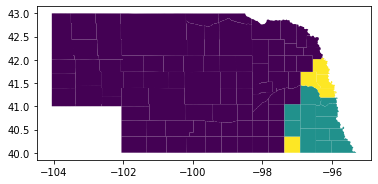

In [207]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID20"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID20'][u]: # Found it
                assignment[u] = j 
                
# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
fig = df.plot(column='assignment').get_figure()

    

In [208]:
# The figure is not contiguous, need to add contiguity constraints.
# Minimize the total perimiter of the district to promote compactness
m.setObjective( gp.quicksum( G.edges[u,v]['shared_perim']*y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [209]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['POP100'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['POP100'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

m.update()

In [223]:
# The figure is not contiguous, need to add contiguity constraints.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG
import networkx as nx
DG = nx.DiGraph(G)
f = m.addVars(DG.edges, vtype=GRB.CONTINUOUS)



In [224]:
# The big-M proposed by Hojny et al.
M = DG.number_of_nodes()- k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in DG.nodes) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in DG.nodes for j in range(k) )

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[u,v] - f[v,u] for u in DG.neighbors(v) ) >= 1 - M * gp.quicksum( r[v,j] for j in range(k)) for v in G.nodes)


# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * (1 - y[i,j]) for (i,j) in G.edges )

m.update()


In [225]:
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2754 rows, 1530 columns and 10239 nonzeros
Model fingerprint: 0xf9d3f44b
Variable types: 462 continuous, 1068 integer (1068 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+05]
  Objective range  [9e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 1074 rows and 0 columns
Presolve time: 0.01s
Presolved: 1680 rows, 1530 columns, 6492 nonzeros
Variable types: 462 continuous, 1068 integer (1068 binary)

Root relaxation: objective 2.691879e-01, 550 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.26919    0  298          -    0.26919      -     -    0s
     0     

In [226]:
#obj.val is the minimum total perimeter distance
print("The minimum optimal perimeter lenght is",m.objval)
# retrieve the districts and their populations
districts1 = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties1 = [ [ G.nodes[i]["NAME20"] for i in districts1[j] ] for j in range(k)]
district_populations1 = [ sum(G.nodes[i]["POP100"] for i in districts1[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations1[j],"and contains counties",district_counties1[j])

The minimum optimal perimeter lenght is 5.447933292060944
District 0 has population 651067 and contains counties ['Sioux', 'Lincoln', 'Sherman', 'Logan', 'Merrick', 'Sheridan', 'Grant', 'Blaine', 'Dixon', 'Stanton', 'Wheeler', 'Franklin', 'Chase', 'Buffalo', 'Fillmore', 'York', 'Clay', 'Cheyenne', 'Garden', 'Harlan', 'Hooker', 'Furnas', 'Howard', 'Valley', 'Cedar', 'Thayer', 'Deuel', 'Morrill', 'Hall', 'Hamilton', 'Loup', 'Frontier', 'Nance', 'Knox', 'Perkins', 'Colfax', 'Butler', 'Cherry', 'Cuming', 'Nuckolls', 'Keith', 'Phelps', 'Webster', 'Dakota', 'Boyd', 'Thomas', 'Holt', 'Brown', 'Keya Paha', 'Banner', 'Greeley', 'Jefferson', 'Dundy', 'Scotts Bluff', 'Adams', 'Kearney', 'Hitchcock', 'Kimball', 'Custer', 'Polk', 'Dawes', 'Wayne', 'Garfield', 'Pierce', 'Platte', 'Box Butte', 'Boone', 'Madison', 'McPherson', 'Red Willow', 'Rock', 'Gosper', 'Dawson', 'Arthur', 'Hayes', 'Antelope']
District 1 has population 654384 and contains counties ['Pawnee', 'Sarpy', 'Saunders', 'Seward', 'Richar

In [227]:
# Draw it on a map
import geopandas as gpd

In [228]:
# Read shapefile from"NE_county.shp"
filename1 = r"C:\Users\Keegan\Downloads\districting-data-2020-county_NE\NE_county.shp"

# Read geopandas dataframe from the file

df2 = gpd.read_file(filename1)

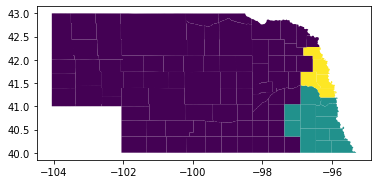

In [230]:
# Which district is each county assigned to?
assignment1 = [ -1 for u in DG.nodes ]
    
# for each district j
for j in range(len(districts1)):
    
    # for each node i in this district
    for i in districts1[j]:
        
        # What is its GEOID?
        geoID1 = DG.nodes[i]["GEOID20"]
        
        # Need to find this GEOID in the dataframe
        for u in DG.nodes:
            if geoID1 == df['GEOID20'][u]: # Found it
                assignment1[u] = j 
                
# Now add the assignments to a column of the dataframe and map it
df2['assignment1'] = assignment1
fig1 = df2.plot(column='assignment1').get_figure()

    